In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
gc.enable()

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
daily_PM10 = pd.read_csv("./daily_all_03_19_Maj.csv", sep=";")   

In [3]:
daily_PM10.head()   # ok

,Jednostka,ug/m3
0,1.05.2003,40.5
1,2.05.2003,43.9
2,3.05.2003,39.5
3,4.05.2003,34.2
4,5.05.2003,55.8


In [4]:
daily_PM10.tail()   # ok

,Jednostka,ug/m3
5840,27.04.2019,39.8
5841,28.04.2019,34.1
5842,29.04.2019,25.0
5843,30.04.2019,29.4
5844,1.05.2019,36.9


In [5]:
daily_PM10.info()   # around 400 null rows...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5845 entries, 0 to 5844
Data columns (total 2 columns):
Jednostka    5845 non-null object
ug/m3        5489 non-null float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB


In [6]:
daily_PM10 = daily_PM10

In [7]:
daily_PM10.head()

,Jednostka,ug/m3
0,1.05.2003,40.5
1,2.05.2003,43.9
2,3.05.2003,39.5
3,4.05.2003,34.2
4,5.05.2003,55.8


In [8]:
daily_PM10.describe()

,ug/m3
count,5489.000000
mean,71.039370
std,49.962966
min,6.500000
25%,38.800000
50%,55.600000
75%,86.200000
max,638.500000


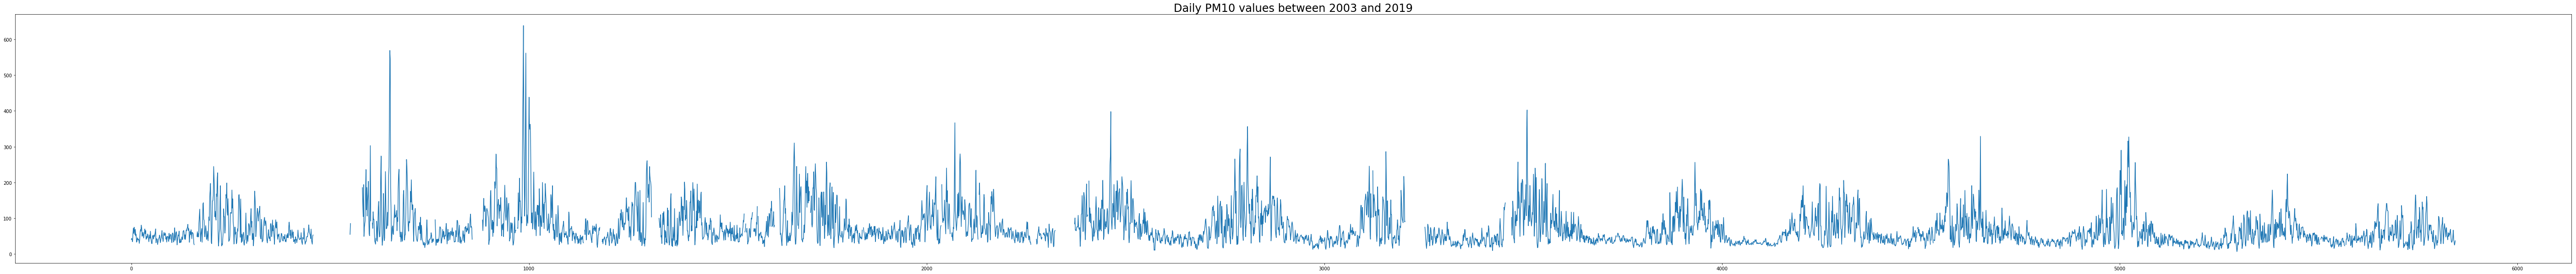

In [9]:
plt.figure(figsize=(100,10))
plt.plot(daily_PM10["ug/m3"])    # already numeric data (Great)
plt.title("Daily PM10 values between 2003 and 2019", fontsize=36)
plt.savefig("untouched_data.png")
plt.show()

In [10]:
# let's fill the null values

numerical = daily_PM10["ug/m3"]


for i in range(len(numerical)):
    if np.isnan(numerical[i]):      
        numerical[i] = np.mean(numerical[i+363:i+367])


for i in range(len(numerical)):
    if np.isnan(numerical[i]):      
        numerical[i] = np.mean(numerical[i-5:i+5])
        
for i in range(len(numerical)):
    if numerical[i] > 400:
        numerical[i] = 400

#for i in range(len(numerical)):
 #   numerical[i] = np.mean(numerical[i-1:i+1])

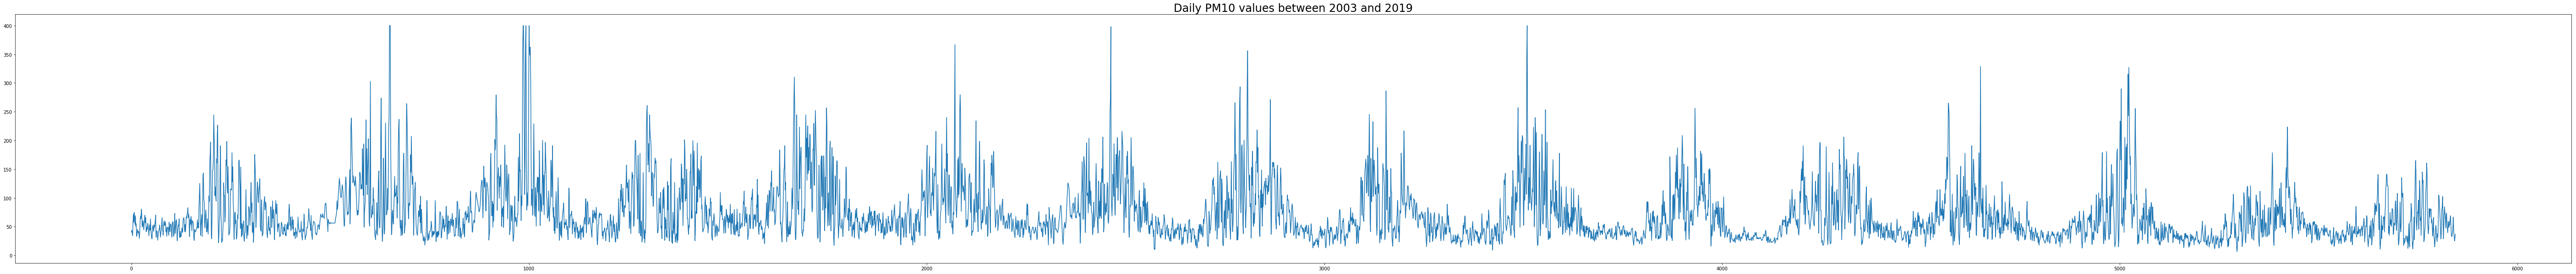

In [11]:
plt.figure(figsize=(100,10))
plt.plot(numerical)    # already numeric data (Great)
plt.title("Daily PM10 values between 2003 and 2019", fontsize=36)
plt.savefig("fixed_data.png")
plt.show()

In [12]:
np.isnan(numerical).any()

False

In [13]:
pd.DataFrame(numerical).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5845 entries, 0 to 5844
Data columns (total 1 columns):
ug/m3    5845 non-null float64
dtypes: float64(1)
memory usage: 45.7 KB


In [14]:
frame_size = 20
label_size = 1

numerical = np.array(numerical)

numerical = numerical.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))    
numerical = scaler.fit_transform(numerical)

numerical.shape

(5845, 1)

In [15]:
train_x = []
train_y = []

for x in range(numerical.shape[0]-(frame_size+label_size)):
    train_x.append(numerical[x:(x+frame_size)])
    train_y.append(numerical[(x+frame_size):(x+frame_size+label_size)])

In [16]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [17]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

train_x = train_x.reshape(-1,frame_size,1)
train_y = train_y.reshape(-1,label_size)
test_x = test_x.reshape(-1,frame_size,1)
test_y = test_y.reshape(-1,label_size)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(5241, 20, 1)
(5241, 1)
(583, 20, 1)
(583, 1)


In [18]:
print(np.isnan(train_x).any())
print(np.isnan(train_y).any())
print(np.isnan(test_x).any())
print(np.isnan(test_y).any())

False
False
False
False


In [19]:
model_daily = Sequential()

model_daily.add(LSTM(24,activation="tanh",return_sequences=True, input_shape=(train_x.shape[1],1)))
model_daily.add(Dropout(0.1))

model_daily.add(LSTM(16,activation="tanh",return_sequences=False))
model_daily.add(Dropout(0.1))

model_daily.add(Dense(label_size))

In [20]:
model_daily.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 24)            2496      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 24)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2624      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 5,137
Trainable params: 5,137
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_daily.compile(optimizer="adam",loss="mse")

In [22]:
history = model_daily.fit(x=train_x,y=train_y,batch_size=100,epochs=50,validation_data=(test_x,test_y))

Train on 5241 samples, validate on 583 samples
Epoch 1/50
5241/5241 [==============================] - 8s 2ms/step - loss: 0.0154 - val_loss: 0.0094
Epoch 2/50
5241/5241 [==============================] - 4s 817us/step - loss: 0.0107 - val_loss: 0.0088
Epoch 3/50
5241/5241 [==============================] - 4s 847us/step - loss: 0.0104 - val_loss: 0.0088
Epoch 4/50
5241/5241 [==============================] - 4s 811us/step - loss: 0.0101 - val_loss: 0.0086
Epoch 5/50
5241/5241 [==============================] - 4s 809us/step - loss: 0.0100 - val_loss: 0.0085
Epoch 6/50
5241/5241 [==============================] - 4s 824us/step - loss: 0.0097 - val_loss: 0.0084
Epoch 7/50
5241/5241 [==============================] - 4s 818us/step - loss: 0.0095 - val_loss: 0.0081
Epoch 8/50
5241/5241 [==============================] - 4s 815us/step - loss: 0.0087 - val_loss: 0.0079
Epoch 9/50
5241/5241 [==============================] - 4s 821us/step - loss: 0.0085 - val_loss: 0.0075
Epoch 10/50
5241/52

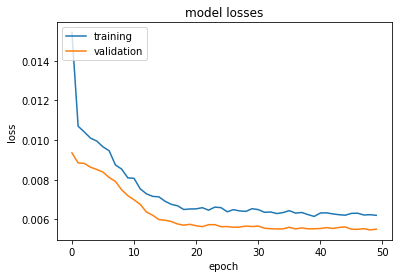

In [30]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig("losses.png")
plt.show()

In [31]:
model_daily.save("daily_model.h5")

In [32]:
predictions = model_daily.predict(test_x)

gc.collect()

4781

In [33]:
print(predictions[100:120])

[[0.11556962]
 [0.47397286]
 [0.44480935]
 [0.09997199]
 [0.1746136 ]
 [0.10287695]
 [0.0678082 ]
 [0.09065479]
 [0.09886147]
 [0.20338225]
 [0.09906328]
 [0.3864431 ]
 [0.15011077]
 [0.06944865]
 [0.19712335]
 [0.0794818 ]
 [0.22805282]
 [0.09568791]
 [0.3301214 ]
 [0.14238578]]


In [34]:
print(test_y[100:120])

[[0.10749682]
 [0.77204574]
 [0.41550191]
 [0.09504447]
 [0.1407878 ]
 [0.15959339]
 [0.07852605]
 [0.04498094]
 [0.0935197 ]
 [0.36213469]
 [0.06073698]
 [0.25260483]
 [0.1021601 ]
 [0.04752224]
 [0.2068615 ]
 [0.06683609]
 [0.28386277]
 [0.06175349]
 [0.31689962]
 [0.10927573]]


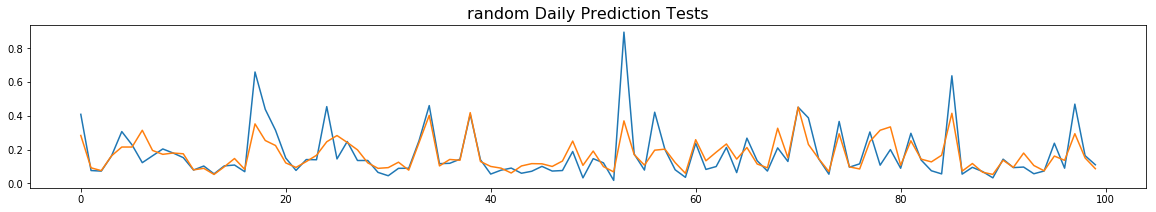

In [35]:
plt.figure(figsize=(20,3))
plt.plot(test_y[:100])
plt.plot(predictions[:100])
plt.title("random Daily Prediction Tests", fontsize=16)
plt.savefig("plot_test.png")
plt.show()

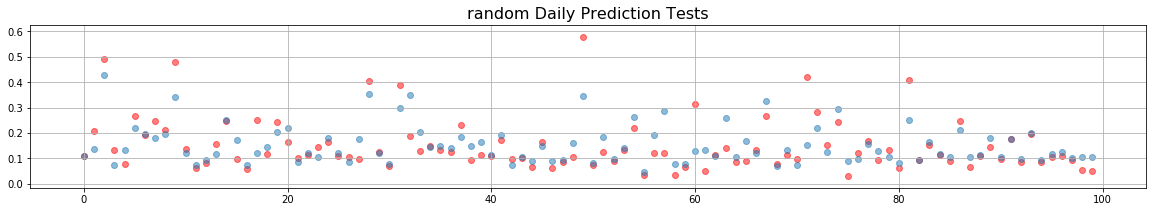

In [36]:
ranger = 100

plt.figure(figsize=(20,3))
plt.scatter(range(ranger),test_y[-ranger:], alpha=0.5, c="red")
#plt.plot(test_y[-ranger:], c="red")
plt.scatter(range(ranger),predictions[-ranger:], alpha=0.5)
plt.title("random Daily Prediction Tests", fontsize=16)
plt.grid()
plt.savefig("sca_test.png")
plt.show()

In [37]:
model_daily.evaluate(test_x,test_y)

583/583 [==============================] - 1s 1ms/step


0.0055009459600045855

In [38]:
#score
def the_score(prediction_y,real_y):
    all_sim = []
    for i in range(len(prediction_y)):
    
        difference = np.absolute(prediction_y[i]-real_y[i])
        
        if difference == 0:
            difference = 0.0000000000000000001
            
        rev_similarity = np.absolute(difference/real_y[i])
        score = 1 - rev_similarity
        score = np.float32(score)
        if score < 0.1:
            score = 0.0          
        all_sim.append(score)
    
    return np.mean(all_sim)    

In [39]:
the_score(predictions, test_y)

array([0.6729844], dtype=float32)

In [40]:
from sklearn.metrics import r2_score

In [41]:
r2_score(test_y, predictions)

0.5725084233474982